# Victim and case related features cleaning
Features that have missing values and are victim related:
- race
- race source
- age
- name
- gender

Features that have missing values and are case related:
- armed_with
- threat_type
- flee_status

To impute some of the features bigger dataset was retrieved;
- Dataset is called Fatal Encounters
- Fatal Encounters is a database of people killed during interactions with police
- Fatal Encounters link: https://fatalencounters.org

Imputation strategy:
- Fatal encounters database is used to retrieve missing values.
- If feature is not found in Fatal encounters database, where possible computational way of imputation is used, such as guessing gender and race.
- Imputation quality is evaluated manually and comparing already known values with potentially imputed values or computationally for example using fuzzywuzzy library.
- After imputation, retrieved values are normalized according to washington post dataset readme.
- Data about the values that were imputed is noted in a separate column, where initially received data is flagged as "Washington_Post". Imputed data source is identified, such as "Fatal_Encounters".
- Missing Age data values are filled using mode of feature, to reduce impact to the statistical features.
- Other missing features are filled with "undetermined"

In [1]:
# %load_ext pycodestyle_magic

In [2]:
# %pycodestyle_on

In [3]:
# Necessary libraries are imported
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from ethnicolr import census_ln
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore, shapiro
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import folium
import seaborn as sns
from scipy.stats import kstest

In [4]:
# Importing dataset with imputed location data
washington_post = pd.read_csv(
    "washington_post_v3_clean.csv", index_col=0, header=0
)
washington_post.head()

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
id,,,,,,,,,,,,,,,,,,
3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


In [5]:
# Importing Fatal Encounters data
file_path = (
    "/Users/agnekrupinskaite/PycharmProjects/"
    "agkrupi-DWWP.4.1/Data_sources/"
    "FATAL ENCOUNTERS DOT ORG SPREADSHEET "
    "(See Read me tab) - Form Responses.csv"
)
fatal_encounters = pd.read_csv(
    file_path, low_memory=False, index_col=0, header=0
)
fatal_encounters.head()

,Name,Age,Gender,Race,Race with imputations,Imputation probability,URL of image (PLS NO HOTLINKS),Date of injury resulting in death (month/day/year),Location of injury (address),Location of death (city),...,URL Temp,Brief description,"Dispositions/Exclusions INTERNAL USE, NOT FOR ANALYSIS",Intended use of force (Developing),Supporting document link,"Foreknowledge of mental illness? INTERNAL USE, NOT FOR ANALYSIS",Unnamed: 32,Unnamed: 33,Unique ID formula,Unique identifier (redundant)
Unique ID,,,,,,,,,,,,,,,,,,,,,
31495.0,Ashley McClendon,28,Female,African-American/Black,African-American/Black,Not imputed,https://fatalencounters.org/wp-content/uploads...,12/31/2021,South Pearl Street and Tory Road,Pageland,...,NaN,"Ashley McClendon's boyfriend, 33-year-old Marc...",Criminal,Pursuit,https://www.wsoctv.com/news/1-person-dead-afte...,No,NaN,NaN,NaN,31495.0
31496.0,Name withheld by police,NaN,Female,Race unspecified,NaN,NaN,NaN,12/31/2021,1500 21st Street,Meridian,...,NaN,Police responded to a man causing a disturbanc...,Pending investigation,Deadly force,https://www.wtok.com/2022/01/01/officer-involv...,No,NaN,NaN,NaN,31496.0
31497.0,Name withheld by police,NaN,Male,Race unspecified,NaN,NaN,NaN,12/31/2021,1500 21st Street,Meridian,...,NaN,Police responded to a man causing a disturbanc...,Pending investigation,Deadly force,https://www.wtok.com/2022/01/01/officer-involv...,No,NaN,NaN,NaN,31497.0
31491.0,Johnny C. Martin Jr.,36,Male,Race unspecified,NaN,NaN,NaN,12/30/2021,Martinez Lane,Nicholls,...,NaN,"Johnny C. Martin, Jr. arrived at a gas station...",Suicide,Suicide,https://gbi.georgia.gov/press-releases/2021-12...,No,NaN,NaN,NaN,31491.0
31492.0,Dennis McHugh,44,Male,European-American/White,NaN,NaN,NaN,12/30/2021,435 E 4th Street,Beaumont,...,NaN,Deputies responded to a domestic violence call...,Pending investigation,Deadly force,https://kesq.com/news/2021/12/31/officer-invol...,No,NaN,NaN,NaN,31492.0


In [6]:
# Counting how many NaN values in each column
null_columns = (
    washington_post.isnull().sum().sort_values(ascending=False)
)
victim_case_features = [
    "name",
    "gender",
    "race",
    "race_source",
    "age",
    "armed_with",
    "threat_type",
    "flee_status",
]
null_columns[victim_case_features].sort_values(ascending=False)

flee_status    1282
race           1171
race_source    1141
age             388
name            352
armed_with      212
threat_type      67
gender           25
dtype: int64

To use Fatal Encounters dataset for queries it should be modified:
- feature names should match working dataset
- datatypes should match between compared columns
- date format should be changed
- fatal encounters dataset data is collected for longer time period. To avoid false positive data retrieval, date intervals should be matched

In [7]:
# Changing the column name in fatal encounters dataset
fatal_encounters = fatal_encounters.rename(
    columns={
        " Date of injury resulting in "
        "death (month/day/year)": "date"
    }
)

# Standardizing date column in both datasets
fatal_encounters["date"] = pd.to_datetime(fatal_encounters["date"])
washington_post["date"] = pd.to_datetime(washington_post["date"])

# Changing date format in fatal encounters dataset
fatal_encounters["date"] = fatal_encounters["date"].dt.strftime(
    "%Y-%m-%d"
)

# Dropping unnecessary rows from fatal encounters dataset
start_date = "1999-12-13"
end_date = "2015-01-01"
fatal_encounters = fatal_encounters[
    (fatal_encounters["date"] < start_date)
    | (fatal_encounters["date"] > end_date)
]

# Turning date column into date
fatal_encounters["date"] = pd.to_datetime(fatal_encounters["date"])

In [8]:
# Checking dataset column names
fatal_encounters.columns

Index(['Name', 'Age', 'Gender', 'Race', 'Race with imputations',
       'Imputation probability', 'URL of image (PLS NO HOTLINKS)', 'date',
       'Location of injury (address)', 'Location of death (city)', 'State',
       'Location of death (zip code)', 'Location of death (county)',
       'Full Address', 'Latitude', 'Longitude', 'Agency or agencies involved',
       'Highest level of force', 'UID Temporary', 'Name Temporary',
       'Armed/Unarmed', 'Alleged weapon', 'Aggressive physical movement',
       'Fleeing/Not fleeing', 'Description Temp', 'URL Temp',
       'Brief description',
       'Dispositions/Exclusions INTERNAL USE, NOT FOR ANALYSIS',
       'Intended use of force (Developing)', 'Supporting document link',
       'Foreknowledge of mental illness? INTERNAL USE, NOT FOR ANALYSIS',
       'Unnamed: 32', 'Unnamed: 33', 'Unique ID formula',
       'Unique identifier (redundant)'],
      dtype='object')

In [9]:
# Changing feature names in the fatal encounters dataset
fatal_encounters = fatal_encounters.rename(
    columns={
        "State": "state",
        "Name": "name",
        "Location of death (city)": "city",
        "Race": "race",
        "Age": "age",
        "Gender": "gender",
        "Location of death (county)": "county",
        "Fleeing/Not fleeing": "flee_status",
        "Alleged weapon": "armed_with",
        "Aggressive physical movement": "threat_type",
    }
)

# Changing dataset feature format
fatal_encounters["gender"] = fatal_encounters["gender"].str.lower()
fatal_encounters["age"] = fatal_encounters["age"].astype(float)

In [10]:
# Removing unnecessary columns
column_list = [
    "URL of image (PLS NO HOTLINKS)",
    "UID Temporary",
    "Name Temporary",
    "Description Temp",
    "URL Temp",
    "Dispositions/Exclusions INTERNAL " "USE, NOT FOR ANALYSIS",
    "Supporting document link",
    "Unnamed: 32",
    "Unnamed: 33",
    "Unique ID formula",
    "Unique identifier (redundant)",
]
fatal_encounters = fatal_encounters.drop(columns=column_list)

In [11]:
# Checking dataset column names after change
fatal_encounters.head()

,name,age,gender,race,Race with imputations,Imputation probability,date,Location of injury (address),city,state,...,Longitude,Agency or agencies involved,Highest level of force,Armed/Unarmed,armed_with,threat_type,flee_status,Brief description,Intended use of force (Developing),"Foreknowledge of mental illness? INTERNAL USE, NOT FOR ANALYSIS"
Unique ID,,,,,,,,,,,,,,,,,,,,,
31495.0,Ashley McClendon,28.0,female,African-American/Black,African-American/Black,Not imputed,2021-12-31,South Pearl Street and Tory Road,Pageland,SC,...,-80.393057,Pageland Police Department,Vehicle,NaN,NaN,NaN,NaN,"Ashley McClendon's boyfriend, 33-year-old Marc...",Pursuit,No
31496.0,Name withheld by police,NaN,female,Race unspecified,NaN,NaN,2021-12-31,1500 21st Street,Meridian,MS,...,-88.693972,Meridian Police Department,Gunshot,NaN,NaN,NaN,NaN,Police responded to a man causing a disturbanc...,Deadly force,No
31497.0,Name withheld by police,NaN,male,Race unspecified,NaN,NaN,2021-12-31,1500 21st Street,Meridian,MS,...,-88.693972,Meridian Police Department,Gunshot,NaN,NaN,NaN,NaN,Police responded to a man causing a disturbanc...,Deadly force,No
31491.0,Johnny C. Martin Jr.,36.0,male,Race unspecified,NaN,NaN,2021-12-30,Martinez Lane,Nicholls,GA,...,-82.637819,Coffee County Sheriff's Office,Gunshot,NaN,NaN,NaN,NaN,"Johnny C. Martin, Jr. arrived at a gas station...",Suicide,No
31492.0,Dennis McHugh,44.0,male,European-American/White,NaN,NaN,2021-12-30,435 E 4th Street,Beaumont,CA,...,-116.977150,"Riverside County Sheriff's Department, Beaumon...",Gunshot,NaN,NaN,NaN,NaN,Deputies responded to a domestic violence call...,Deadly force,No


## name feature imputations
- Fatal encounters database is queried to impute some missing names using matching features (state, date, city, gender, age)
- Retrieved strings "Name withheld by police" is change to "undetermined", because this name feature category will not be required for the further analysis.
- Other missing values are filled with "undetermined".

In [12]:
# Function to retrieve names from fatal encounters dataset
def fill_missing_names(state, date, city, gender, age):
    """Fill missing names using matching state, date, city,
    gender and county. Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["state"] == state)
        & (fatal_encounters["date"] == date)
        & (fatal_encounters["city"] == city)
        & (fatal_encounters["gender"] == gender)
        & (fatal_encounters["age"] == age)
    ]

    # Finding matching rows
    if not matching_row.empty:
        return matching_row["name"].iloc[0]

In [13]:
# Filter to identify missing names
name = ["name"]
no_name = washington_post[name].isnull().all(axis=1)
missing_names = washington_post[no_name].shape[0]
print(f"Number of missing names: {missing_names}.")

Number of missing names: 352.


In [14]:
# Applying fill_missing_names function
washington_post["Retrieved_name"] = washington_post.apply(
    lambda row: fill_missing_names(
        row["state"],
        row["date"],
        row["city"],
        row["gender"],
        row["age"],
    ),
    axis=1,
)

In [15]:
# Checking how many values were retrieved
retrieved_names_count = (
    washington_post["Retrieved_name"].notnull().sum()
)
print(
    f"Number of retrieved names for whole dataset: "
    f"{retrieved_names_count}."
)

Number of retrieved names for whole dataset: 4965.


In [16]:
# Names retrieved for missing name values (manual review)
name_retrieved = washington_post.Retrieved_name.notnull()
retrieved_name_count = washington_post[["name", "Retrieved_name"]][
    no_name & name_retrieved
].shape[0]
print(
    f"Number of of retrieved names for missing names: "
    f"{retrieved_name_count}."
)
washington_post[["name", "Retrieved_name"]][no_name & name_retrieved]

Number of of retrieved names for missing names: 35.


,name,Retrieved_name
id,,
2494,NaN,Jarrad Lamark Hill
2552,NaN,Joseph Tourino
2837,NaN,James Lacy
3198,NaN,Kyle Gray
3651,NaN,Allen Ray Mitchell
4142,NaN,Name withheld by police
4454,NaN,Randy Sanchez
4828,NaN,"Carmine Giuseppe ""C.J."" Fazzolari"
4898,NaN,Jamal Muhammad


Name values were retrieved from Fatal Encounters dataset. Two features were checked:
- How many names match retrieved names (None values excluded)?
- How many names do not match retrieved names (None values excluded)?

In [17]:
# Retrieved_names that match names feature
name_exists = washington_post["name"].notnull()
names_match = washington_post["name"].isin(
    washington_post["Retrieved_name"]
)
amount_of_names = washington_post[["name", "Retrieved_name"]][
    names_match & name_exists
].shape[0]
print(f"Number of names that match: {amount_of_names}.")

Number of names that match: 3528.


In [18]:
# Names retrieved for not missing name values that do not match
name_retrieved = washington_post["Retrieved_name"].notnull()
no_match = (
    washington_post["name"] != washington_post["Retrieved_name"]
)
no_match_count = washington_post[
    [
        "name",
        "Retrieved_name",
    ]
][
    name_exists & no_match & name_retrieved
].shape[0]
print(f"Number of names that do not match: {no_match_count}.")
washington_post[
    [
        "name",
        "Retrieved_name",
    ]
][name_exists & no_match & name_retrieved];

Number of names that do not match: 1428.


In [19]:
# Counting the amount of all retrieved names
retrieved_names_count = (
    washington_post["Retrieved_name"].notnull().sum()
)

In [20]:
# How many retrieved names do not match
no_match_percentage = round(
    100 - amount_of_names * 100 / retrieved_names_count, 0
)
print(
    f"Percentage of names that do not match: "
    f"{no_match_percentage} %."
)

Percentage of names that do not match: 29.0 %.


### Identifying mistakes in name retrieval
Since percentage of names that do not match is 29.0 % it is important to check why these names do not match. To perform this task fuzzywuzzy library was used and name similarity percentage was checked. Dataframe was filtered to show names that have similarity match lower than 80%. Results were reviewed manually.

In [21]:
# Calculating similarity ratio between name features
def similarity_ratio(row):
    """Calculates similarity between two rows of
    name and Retrieved_name."""
    return fuzz.ratio(row["name"], row["Retrieved_name"])


washington_post["name_similarity"] = washington_post[
    name_exists & no_match & name_retrieved
].apply(similarity_ratio, axis=1)

In [22]:
# Names retrieved for not missing name values that do not match
name_exists = washington_post["name"].notnull()
name_retrieved = washington_post["Retrieved_name"].notnull()
no_match = (
    washington_post["name"] != washington_post["Retrieved_name"]
)
no_match_count = washington_post[
    ["name", "Retrieved_name", "name_similarity"]
][name_exists & no_match & name_retrieved].shape[0]
print(
    f"Number of retrieved names that do not match "
    f"with existing names: {no_match_count}."
)

Number of retrieved names that do not match with existing names: 1428.


In [23]:
# Filtering names with low similarity for manual evaluation
low_name_similarity = washington_post.name_similarity < 80
washington_post[["name", "Retrieved_name", "name_similarity"]][
    low_name_similarity
];

In [24]:
# Name missmatch manual review
index_for_missmatch = [
    7061,
    4644,
    6421,
    1927,
    6191,
    6693,
    3018,
    6358,
    7489,
]
missmatch_rows = washington_post.loc[index_for_missmatch]
missmatch_rows[
    [
        "date",
        "name",
        "Retrieved_name",
        "age",
        "gender",
        "state",
        "city",
        "county",
        "race",
    ]
]

,date,name,Retrieved_name,age,gender,state,city,county,race
id,,,,,,,,,
7061,2021-07-31,Adam S. Moser,Name withheld by police,39.0,male,FL,Yulee,Nassau,W
4644,2019-04-11,Christopher Michael Alderete,Name withheld by police,20.0,male,TX,Canutillo,El Paso,H
6421,2020-12-11,David Kenneth Christie,Name withheld by police,35.0,male,MT,Trout Creek,Sanders County,W
1927,2016-09-30,George Richards-Meyers,Najier Salaam,18.0,male,NJ,Newark,Essex,B
6191,2020-09-18,Jeffrey Castillo,Name withheld by police,39.0,male,CA,Redlands,San Bernardino County,H
6693,2021-03-09,Jehlani Jay Black,Name withheld by police,19.0,male,CA,Riverside,Riverside County,B
3018,2017-10-05,Johnny Ray Leeds Jr.,Johnny Roy Stokes Jr.,40.0,male,AL,Leeds,Jefferson,W
6358,2020-11-03,Jonathan Torres Ramirez,Name withheld by police,20.0,male,CA,Oakland,Alameda County,H
7489,2021-12-15,Sergio Baldemar Escalera Valdez,Name withheld by police,45.0,male,CA,North Richmond,Contra Costa,NaN


In [25]:
# Observation 9594 fixes
washington_post.loc[4405, "Retrieved_name"] = "Preston Oszust"

In [26]:
# Manual name fix, because these names have high similarity
washington_post.loc[1927, "Retrieved_name"] = "George Richards-Meyers"
washington_post.loc[1577, "Retrieved_name"] = (
    "Donald Edward Brown III"
)
washington_post.loc[5261, "Retrieved_name"] = "Ronnie Jerome Hill"

# After manual checkup does not need any change
washington_post.loc[2675];

In [27]:
# Missing names evaluation (manual)
name_not_withheld_by_police = (
    washington_post.Retrieved_name != "Name withheld by police"
)

washington_post[
    [
        "date",
        "name",
        "Retrieved_name",
        "age",
        "gender",
        "state",
        "city",
        "county",
        "race",
    ]
][no_name & name_retrieved & name_not_withheld_by_police]

,date,name,Retrieved_name,age,gender,state,city,county,race
id,,,,,,,,,
2494,2017-04-10,NaN,Jarrad Lamark Hill,39.0,male,TX,Houston,Harris,B
2552,2017-05-03,NaN,Joseph Tourino,28.0,male,CA,San Jose,Santa Clara,NaN
2837,2017-08-04,NaN,James Lacy,47.0,male,CA,San Diego,San Diego,B
3198,2017-12-11,NaN,Kyle Gray,24.0,male,WA,Seattle,King,W
3651,2018-04-29,NaN,Allen Ray Mitchell,42.0,male,CA,Redlands,San Bernardino,W
4454,2019-01-31,NaN,Randy Sanchez,24.0,male,NJ,Passaic,Passaic County,NaN
4828,2019-06-28,NaN,"Carmine Giuseppe ""C.J."" Fazzolari",24.0,male,TX,Houston,Harris,W
4898,2019-07-27,NaN,Jamal Muhammad,42.0,male,TX,Dallas,Dallas County,B
5470,2019-08-21,NaN,Jesus Ocasio,54.0,male,IL,North Aurora,Kane County,NaN


One of the values retrieved is string "Name witheld by police". In the further analysis this category will not be analysed, therefore it is changed it to "undetermined" 

In [28]:
# Removing "Name withheld by police" string
name_withheld_by_police = (
    washington_post.Retrieved_name == "Name withheld by police"
)
washington_post.loc[name_withheld_by_police, "Retrieved_name"] = (
    "undetermined"
)

To identify which values were retrieved from Fatal Encounters database, new column is created using column masking and fillna methods.

In [29]:
# Create masks for not null values
name_mask = washington_post["name"].notnull()
washington_post["name_source"] = name_mask
washington_post["FE_name_source"] = name_retrieved

# Replacing newly created column values to flags
washington_post.name_source.replace(
    True, "Washington_Post", inplace=True
)
washington_post.name_source.replace(False, np.nan, inplace=True)
washington_post.FE_name_source.replace(
    True, "Fatal_Encounters", inplace=True
)
washington_post.FE_name_source.replace(False, np.nan, inplace=True)

# Replacing name with retrieved names
washington_post["name"].fillna(
    washington_post["Retrieved_name"], inplace=True
)
washington_post.name_source.fillna(
    washington_post.FE_name_source, inplace=True
)

Missing name values that were not retrieved from the Fatal Encounters database will be filled with string "undetermined" creating new group for analysis and maintaining as much data as possible.

In [30]:
# Last missing values filled with undetermined
washington_post.name.fillna("undetermined", inplace=True)
washington_post.name_source.fillna("undetermined", inplace=True)

# Checking if the flagging was successful
washington_post.name_source.value_counts()

name_source
Washington_Post     9026
undetermined         317
Fatal_Encounters      35
Name: count, dtype: int64

In [31]:
# Unnecessary column removed
washington_post.drop("FE_name_source", axis=1, inplace=True)

In [32]:
# Checking how many names are still missing
missing_values = washington_post.name.isnull().sum()
missing_source = washington_post.name.isnull().sum()
print(f"Missing values in name feature: {missing_values}.")
print(f"Missing values in name_source feature: {missing_source}.")

Missing values in name feature: 0.
Missing values in name_source feature: 0.


### Name feature modifications:
- Full names in name feature has different amount of strings. To use this feature for race and gender determination (will be done later in this notebook) full names should be split into strings.
- Since some names do not match their retrieved names due to different data sources using different data standardisation techniques, name column in Fatal Encounters dataset was copied and renamed to "Retrieved_names". This allows to query Fatal Encounters dataset using originally provided names and retrieved names and gives potential to retrieve more missing data.

In [33]:
# Split the 'name' feature into separate strings
split_names = washington_post["name"].str.split(r"[ -]", expand=True)

washington_post["first_name"] = split_names[0]
washington_post["second_name"] = split_names[1]
washington_post["third_name"] = split_names[2]
washington_post["fourth_name"] = split_names[3]
washington_post["fifth_name"] = split_names[4]

columns = [
    "first_name",
    "second_name",
    "third_name",
    "fourth_name",
    "fifth_name",
]
# Missing columns filled with X not to create constant
for column in columns:
    washington_post[column].fillna("X", inplace=True)

In [34]:
# Creating a fatal encounters copy for feature retrieval
fatal_encounters["X"] = fatal_encounters["name"].copy()
fatal_encounters = fatal_encounters.rename(
    columns={"X": "Retrieved_name"}
)

## gender feature imputations
- Gender feature is retrieved using name, Retrieved_name and date features from Fatal Encounters dataset.
- Missing values are imputed using gender_guesser library and first name of the person.
- Other missing values are filled with undetermined.
- Imputed values flag is provided.

In [35]:
# Function to retrieve gender from date and name
def fill_missing_gender_v1(date, name):
    """Fill missing names using matching state, date,
    city and Retrieved_name columns.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["date"] == date)
        & (fatal_encounters["name"] == name)
    ]

    # Finding matching rows
    if not matching_row.empty:
        return matching_row["gender"].iloc[0]

In [36]:
# Function to retrieve gender from date and Retrieved_name
def fill_missing_gender_v2(date, Retrieved_name):
    """Fill missing names using matching state, date,
    city and Retrieved_name columns.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["date"] == date)
        & (fatal_encounters["Retrieved_name"] == Retrieved_name)
    ]

    # Finding matching rows
    if not matching_row.empty:
        return matching_row["gender"].iloc[0]

In [37]:
# Count missing gender values
gender = ["gender"]
no_gender = washington_post[gender].isnull().all(axis=1)
no_gender_count = washington_post[no_gender].shape[0]
print(f"Missing gender feature values count: " f"{no_gender_count}.")

Missing gender feature values count: 25.


In [38]:
# Retrieving missing gender values
washington_post["Retrieved_gender_v1"] = washington_post.apply(
    lambda row: fill_missing_gender_v1(row["date"], row["name"]),
    axis=1,
)

In [39]:
# Applying fill_missing_gender function
washington_post["Retrieved_gender_v2"] = washington_post.apply(
    lambda row: fill_missing_gender_v2(
        row["date"], row["Retrieved_name"]
    ),
    axis=1,
)

In [40]:
# Evaluating results of fill_missing_gender_v1
gender_retrieved_v1 = washington_post.Retrieved_gender_v1.notnull()
washington_post[
    ["name", "gender", "Retrieved_gender_v1", "Retrieved_gender_v2"]
][no_gender & gender_retrieved_v1].head()

,name,gender,Retrieved_gender_v1,Retrieved_gender_v2
id,,,,
2956,Scout Schultz,NaN,transgender,None


In [41]:
# Evaluating results of fill_missing_gender_v2
gender_retrieved_v2 = washington_post.Retrieved_gender_v2.notnull()
washington_post[
    ["name", "gender", "Retrieved_gender_v1", "Retrieved_gender_v2"]
][no_gender & gender_retrieved_v2].head()

,name,gender,Retrieved_gender_v1,Retrieved_gender_v2
id,,,,


In [42]:
# Using gender_guesser to impute gender values
import gender_guesser.detector as gender

d = gender.Detector()
washington_post["Retrieved_gender_guesser"] = washington_post.apply(
    lambda row: d.get_gender(row["first_name"]), axis=1
)

In [43]:
# Reviewing gender_guesser results
gg_retrieved = washington_post.Retrieved_gender_guesser.notnull()
gg_known = washington_post.Retrieved_gender_guesser != "unknown"
gg_count = washington_post[
    [
        "name",
        "gender",
        "Retrieved_gender_v1",
        "Retrieved_gender_guesser",
    ]
][no_gender & gg_retrieved & gg_known].shape[0]
print(
    f"Gender values retrieved by gender_guesser "
    f"for missing genders: {gg_count}."
)
washington_post[
    [
        "name",
        "gender",
        "Retrieved_gender_v1",
        "Retrieved_gender_guesser",
    ]
][no_gender & gg_retrieved & gg_known]

Gender values retrieved by gender_guesser for missing genders: 7.


,name,gender,Retrieved_gender_v1,Retrieved_gender_guesser
id,,,,
7947,Larry Marquail Mixon III,NaN,None,male
8109,Kevin Colindres,NaN,None,male
8103,Joseph Robert Henry Thompson,NaN,None,male
8510,Jeffery J. Smith,NaN,None,male
8563,Timothy Wayne Hodges,NaN,None,male
8574,Ethan Huiras,NaN,None,male
9057,Audrey Elizabeth Hale,NaN,None,female


In [44]:
# Create masks for not null values
gender_mask = washington_post["gender"].notnull()
washington_post["gender_source"] = gender_mask
washington_post["filled_gender_v1"] = gender_retrieved_v1
washington_post["filled_gender_v2"] = gender_retrieved_v2
washington_post["filled_gender_guesser"] = gg_retrieved

# Replacing newly created column values to flags
washington_post.gender_source.replace(
    True, "Washington_Post", inplace=True
)
washington_post.gender_source.replace(False, np.nan, inplace=True)
washington_post.filled_gender_v1.replace(
    True, "Fatal_Encounters", inplace=True
)
washington_post.filled_gender_v1.replace(False, np.nan, inplace=True)
washington_post.filled_gender_v2.replace(
    True, "Fatal_Encounters", inplace=True
)
washington_post.filled_gender_v2.replace(False, np.nan, inplace=True)
washington_post.filled_gender_guesser.replace(
    True, "gender_guesser", inplace=True
)
washington_post.filled_gender_guesser.replace(
    False, np.nan, inplace=True
)

# Replacing gender with retrieved gender
washington_post["Retrieved_gender_v1"].fillna(
    washington_post["Retrieved_gender_guesser"], inplace=True
)
washington_post.filled_gender_v1.fillna(
    washington_post.filled_gender_guesser, inplace=True
)

# Flagging and filling missing values
washington_post["gender"].fillna(
    washington_post["Retrieved_gender_v1"], inplace=True
)
washington_post.gender_source.fillna(
    washington_post.filled_gender_v1, inplace=True
)
washington_post["gender"] = washington_post["gender"].replace(
    "unknown", "undetermined"
)
washington_post.gender_source.fillna("undetermined", inplace=True)

In [45]:
# Checking if the imputation was successful
missing_gender_source = washington_post.gender_source.isnull()
missing_gender_source_count = washington_post[
    missing_gender_source
].shape[0]
print(
    f"Still missing gender source values: "
    f"{missing_gender_source_count}."
)
washington_post.gender_source.value_counts()

Still missing gender source values: 0.


gender_source
Washington_Post     9353
gender_guesser        24
Fatal_Encounters       1
Name: count, dtype: int64

In [46]:
# Checking if the flagging was successful
missing_gender = washington_post.gender.isnull()
missing_gender_count = washington_post[missing_gender].shape[0]
print(f"Still missing gender values: " f"{missing_gender_count}.")
washington_post.gender.value_counts()

Still missing gender values: 0.


gender
male            8945
female           414
undetermined      17
transgender        1
non-binary         1
Name: count, dtype: int64

In [47]:
# Drop multiple columns
columns_to_drop = [
    "filled_gender_v1",
    "filled_gender_v2",
    "filled_gender_guesser",
]
washington_post.drop(columns_to_drop, axis=1, inplace=True)

## age feature imputations
- Part of age feature values are retrieved from Fatal Shooting database.
- Other values are filled with mode of the age feature.
- New column age_source is created to flag the imputation fact.

In [48]:
# Function to retrieve missing age values
def fill_missing_age_v1(name, date):
    """Fill missing age values using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["name"] == name)
        & (fatal_encounters["date"] == date)
    ]

    # Finding matching rows
    if not matching_row.empty:
        return matching_row["age"].iloc[0]

In [49]:
# Function to retrieve missing age values
def fill_missing_age_v2(Retrieved_name, date):
    """Fill missing age values using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["Retrieved_name"] == Retrieved_name)
        & (fatal_encounters["date"] == date)
    ]

    # Finding matching rows
    if not matching_row.empty:
        return matching_row["age"].iloc[0]

In [50]:
# Filter to identify missing age values
age = ["age"]
no_age = washington_post[age].isnull().all(axis=1)
no_age_count = washington_post[no_age].shape[0]
print(f"Missing age feature values count: {no_age_count}.")

Missing age feature values count: 388.


In [51]:
# Applying fill_missing_age_v1 function
washington_post["Retrieved_age_v1"] = washington_post.apply(
    lambda row: fill_missing_age_v1(row["name"], row["date"]), axis=1
)

In [52]:
# Applying fill_missing_age_v2 function
washington_post["Retrieved_age_v2"] = washington_post.apply(
    lambda row: fill_missing_age_v2(
        row["Retrieved_name"], row["date"]
    ),
    axis=1,
)

In [53]:
# Checking fill_missing_age_v1 function results
age_retrieved_v1 = washington_post.Retrieved_age_v1.notnull()
retrieved_count = washington_post[
    ["name", "age", "Retrieved_age_v1"]
][no_age & age_retrieved_v1].shape[0]
print(
    f"Retrieved age values from v1 function: " f"{retrieved_count}."
)
washington_post[["name", "age", "Retrieved_age_v1"]][
    no_age & age_retrieved_v1
];

Retrieved age values from v1 function: 41.


In [54]:
# Checking fill_missing_age_v2 function results
age_retrieved_v2 = washington_post.Retrieved_age_v2.notnull()
retrieved_count = washington_post[
    ["name", "age", "Retrieved_age_v1"]
][no_age & age_retrieved_v2].shape[0]
print(
    f"Retrieved age values from v2 function: " f"{retrieved_count}."
)
washington_post[["name", "age", "Retrieved_age_v2"]][
    no_age & age_retrieved_v2
];

Retrieved age values from v2 function: 0.


In [55]:
# Filling missing names with names retrieved from Fatal Encounters

# Create new boolean columns based on masks
age_mask = washington_post["age"].notnull()
washington_post["age_source"] = age_mask
washington_post["filled_age_v1"] = age_retrieved_v1
washington_post["filled_age_v2"] = age_retrieved_v2

# Replacing newly created column values to flags
washington_post.age_source.replace(
    True, "Washington_Post", inplace=True
)
washington_post.age_source.replace(False, np.nan, inplace=True)
washington_post.filled_age_v1.replace(
    True, "Fatal_Encounters", inplace=True
)
washington_post.filled_age_v1.replace(False, np.nan, inplace=True)
washington_post.filled_age_v2.replace(
    True, "Fatal_Encounters", inplace=True
)
washington_post.filled_age_v2.replace(False, np.nan, inplace=True)

# Replacing missing age with age retrieved
washington_post["age"].fillna(
    washington_post["Retrieved_age_v1"], inplace=True
)
washington_post.age_source.fillna(
    washington_post.filled_age_v1, inplace=True
)

washington_post["age"].fillna(
    washington_post["Retrieved_age_v2"], inplace=True
)
washington_post.age_source.fillna(
    washington_post.filled_age_v2, inplace=True
)
washington_post.age_source.fillna("mode", inplace=True)

Since age data is numeric data statistical evaluation will be performed for it to analyze the outliers and significance. Therefore, missing age values are filled with mode, that should affect the dataset statistics less.

In [56]:
# Missing values filled with mode
mode_age = washington_post["age"].mode()
washington_post["age"].fillna(mode_age.iloc[0], inplace=True)

In [57]:
# Checking if the imputation was successful
missing_age_source = washington_post.age_source.isnull()
missing_age_source_count = washington_post[missing_age_source].shape[0]
print(
    f"Still missing age source values: "
    f"{missing_age_source_count}."
)
washington_post.age_source.value_counts()

Still missing age source values: 0.


age_source
Washington_Post     8990
mode                 347
Fatal_Encounters      41
Name: count, dtype: int64

In [58]:
# Checking if the flagging was successful
missing_age = washington_post.age.isnull()
missing_age_count = washington_post[missing_age].shape[0]
print(f"Still missing age values: {missing_age_count}.")

Still missing age values: 0.


In [59]:
# Drop multiple columns
columns_to_drop = ["filled_age_v1", "filled_age_v2"]
washington_post.drop(columns_to_drop, axis=1, inplace=True)

## flee_status feature
- In the readme flee_status feature is described as: How, if at all, was the victim moving relative to officers leading up to the shooting.
- Where it is possible values are retrieved from fatal Encounters database.
- Where not possible missing values will be filled with "undetermined".
- New column is created to flag imputecd values.

In [60]:
# Flee_status retrieval using name
def fill_missing_flee_status_v1(name, date):
    """Fill missing flee_status using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["name"] == name)
        & (fatal_encounters["date"] == date)
    ]

    # Find matching row
    if not matching_row.empty:
        return matching_row["flee_status"].iloc[0]

In [61]:
# Flee_status retrieval using Retrieved_name
def fill_missing_flee_status_v2(Retrieved_name, date):
    """Fill missing flee_status using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["Retrieved_name"] == Retrieved_name)
        & (fatal_encounters["date"] == date)
    ]

    # Find matching row
    if not matching_row.empty:
        return matching_row["flee_status"].iloc[0]

In [62]:
# Filter to identify values with missing flee_status
no_flee_status = washington_post.flee_status.isnull()
no_flee_status_count = washington_post[no_flee_status].shape[0]
print(f"Missing values in flee_status: {no_flee_status_count}.")

Missing values in flee_status: 1282.


In [63]:
# Applying fill_missing_flee_status_v1 function
washington_post["Retrieved_flee_status_v1"] = washington_post.apply(
    lambda row: fill_missing_flee_status_v1(row["name"], row["date"]),
    axis=1,
)

In [64]:
# Applying fill_missing_flee_status_v2 function
washington_post["Retrieved_flee_status_v2"] = washington_post.apply(
    lambda row: fill_missing_flee_status_v2(
        row["Retrieved_name"], row["date"]
    ),
    axis=1,
)

In [65]:
# Checking fill_missing_flee_status_v1 results
fs_retrieved_v1 = washington_post[
    "Retrieved_flee_status_v1"
].notnull()
retrieved_fs_v1_count = washington_post[
    ["name", "flee_status", "Retrieved_flee_status_v1"]
][no_flee_status & fs_retrieved_v1].shape[0]
print(f"Retrieved flee status v1: {retrieved_fs_v1_count}.")
washington_post[["name", "flee_status", "Retrieved_flee_status_v1"]][
    no_flee_status & fs_retrieved_v1
];

Retrieved flee status v1: 197.


In [66]:
# Checking fill_missing_flee_status_v2 results
fs_retrieved_v2 = washington_post[
    "Retrieved_flee_status_v2"
].notnull()
retrieved_fs_v2_count = washington_post[
    ["name", "flee_status", "Retrieved_flee_status_v2"]
][no_flee_status & fs_retrieved_v2].shape[0]
print(f"Retrieved flee status v2: {retrieved_fs_v2_count}.")
washington_post[["name", "flee_status", "Retrieved_flee_status_v2"]][
    no_flee_status & fs_retrieved_v2
];

Retrieved flee status v2: 227.


In [67]:
# Filling missing names with names retrieved from Fatal Encounters

# Creating new boolean columns based on masks
flee_status_mask = washington_post["flee_status"].notnull()
washington_post["flee_status_source"] = flee_status_mask
washington_post["filled_flee_status_v1"] = fs_retrieved_v1
washington_post["filled_flee_status_v2"] = fs_retrieved_v2

# Replacing newly created column values to flags
washington_post.flee_status_source.replace(
    True, "Washington_Post", inplace=True
)
washington_post.flee_status_source.replace(
    False, np.nan, inplace=True
)
washington_post.filled_flee_status_v1.replace(
    True, "Fatal_Encounters", inplace=True
)
washington_post.filled_flee_status_v1.replace(
    False, np.nan, inplace=True
)
washington_post.filled_flee_status_v2.replace(
    True, "Fatal_Encounters", inplace=True
)
washington_post.filled_flee_status_v2.replace(
    False, np.nan, inplace=True
)

# Replacing missing flee_status with retrieved_flee_status
washington_post["flee_status"].fillna(
    washington_post["Retrieved_flee_status_v2"], inplace=True
)
washington_post.flee_status_source.fillna(
    washington_post.filled_flee_status_v2, inplace=True
)

washington_post["flee_status"].fillna(
    washington_post["Retrieved_flee_status_v1"], inplace=True
)
washington_post.flee_status_source.fillna(
    washington_post.filled_flee_status_v1, inplace=True
)

In [68]:
# Checking if the imputation was successful
missing_flee_status_source = (
    washington_post.flee_status_source.isnull()
)
missing_flee_status_source_count = washington_post[
    missing_flee_status_source
].shape[0]
print(
    f"Still missing age source values: "
    f"{missing_flee_status_source_count}."
)
washington_post.flee_status_source.value_counts()

Still missing age source values: 1014.


flee_status_source
Washington_Post     8096
Fatal_Encounters     268
Name: count, dtype: int64

In [69]:
# Checking how many flee_status values missing
missing_values = washington_post.flee_status.isnull().sum()
missing_source = washington_post.flee_status_source.isnull().sum()
print(f"Missing values in flee_status feature: {missing_values}.")
print(
    f"Missing values in flee_status_source feature: {missing_values}."
)

Missing values in flee_status feature: 1014.
Missing values in flee_status_source feature: 1014.


In [70]:
# Filling not retrieved values with undetermined
washington_post.flee_status.fillna("undetermined", inplace=True)
washington_post.flee_status_source.fillna(
    "undetermined", inplace=True
)

In [71]:
# Checking if flee_status values need corrections
washington_post.flee_status.value_counts()

flee_status
not                    5027
car                    1491
foot                   1230
undetermined           1014
other                   348
Not fleeing             214
Fleeing/Foot             20
Fleeing/Vehicle          19
Uncertain                12
Fleeing/Motorcycle        2
Fleeing/Unspecified       1
Name: count, dtype: int64

### flee_status values standartization
flee_status values are converted to values compatible with washington post dataset.

In [72]:
# Correcting values to unify data
not_fleeing = washington_post.flee_status == "Not fleeing"
fleeing_foot = washington_post.flee_status == "Fleeing/Foot"
flee_vehicle = washington_post.flee_status == "Fleeing/Vehicle"
flee_motor = washington_post.flee_status == "Fleeing/Motorcycle"
flee_uncertain = washington_post.flee_status == "Uncertain"
flee_unspecified = (
    washington_post.flee_status == "Fleeing/Unspecified"
)

washington_post.loc[not_fleeing, "flee_status"] = "not"
washington_post.loc[fleeing_foot, "flee_status"] = "foot"
washington_post.loc[flee_vehicle, "flee_status"] = "car"
washington_post.loc[flee_motor, "flee_status"] = "other"
washington_post.loc[flee_uncertain, "flee_status"] = "undetermined"
washington_post.loc[flee_unspecified, "flee_status"] = "other"

In [73]:
# Checking if flee_status values need corrections
washington_post.flee_status.value_counts()

flee_status
not             5241
car             1510
foot            1250
undetermined    1026
other            351
Name: count, dtype: int64

In [74]:
# Drop multiple columns
columns_to_drop = ["filled_flee_status_v1", "filled_flee_status_v2"]
washington_post.drop(columns_to_drop, axis=1, inplace=True)

### armed_with feature:
- In the readme armed with feature is described as: What, if anything, was the victim armed with per federal classifications based on NIBRS, the national incident-level crime reporting system. These categories are roughly reflected in local police data and forms.
- Feature is retrieved from Fatal Encounters dataset where possible.
- Not retrieved features are filled with "undetermined".
- Imputed features are flagged in a separate column.

In [75]:
# Checking how many armed_with values missing
missing_values = washington_post.armed_with.isnull().sum()
print(f"Missing values in armed_with feature: {missing_values}.")

Missing values in armed_with feature: 212.


In [76]:
# Armed_with retrieval using name
def fill_missing_armed_with_v1(name, date):
    """Fill missing armed_with using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["name"] == name)
        & (fatal_encounters["date"] == date)
    ]

    # Finding matching rows
    if not matching_row.empty:
        return matching_row["armed_with"].iloc[0]

In [77]:
# Finding matching rows
def fill_missing_armed_with_v2(Retrieved_name, date):
    """Fill missing armed_with using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["Retrieved_name"] == Retrieved_name)
        & (fatal_encounters["date"] == date)
    ]

    # Check if there's a matching row
    if not matching_row.empty:
        return matching_row["armed_with"].iloc[0]

In [78]:
# Applying fill_missing_armed_with_v1 function
washington_post["Retrieved_armed_with_v1"] = washington_post.apply(
    lambda row: fill_missing_armed_with_v1(row["name"], row["date"]),
    axis=1,
)

In [79]:
# Applying fill_missing_armed_with_v2 function
washington_post["Retrieved_armed_with_v2"] = washington_post.apply(
    lambda row: fill_missing_armed_with_v2(row["name"], row["date"]),
    axis=1,
)

In [80]:
# Checking fill_missing_armed_with_v1 results
no_armed_with = washington_post.armed_with.isnull()
aw_retrieved_v1 = washington_post["Retrieved_armed_with_v1"].notnull()
retrieved_aw_v1_count = washington_post[
    ["name", "armed_with", "Retrieved_armed_with_v1"]
][no_armed_with & aw_retrieved_v1].shape[0]
print(f"Retrieved armed_with values by v1: {retrieved_aw_v1_count}.")
washington_post[["name", "armed_with", "Retrieved_armed_with_v1"]][
    no_armed_with & aw_retrieved_v1
];

Retrieved armed_with values by v1: 42.


In [81]:
# Checking fill_missing_armed_with_v2 results
no_armed_with = washington_post.armed_with.isnull()
aw_retrieved_v2 = washington_post["Retrieved_armed_with_v2"].notnull()
retrieved_aw_v2_count = washington_post[
    ["name", "armed_with", "Retrieved_armed_with_v2"]
][no_armed_with & aw_retrieved_v2].shape[0]
print(f"Retrieved armed_with values by v2: {retrieved_aw_v2_count}.")
washington_post[["name", "armed_with", "Retrieved_armed_with_v2"]][
    no_armed_with & aw_retrieved_v2
];

Retrieved armed_with values by v2: 42.


In [82]:
# Checking if missing retrieved values match
match = (
    washington_post.Retrieved_armed_with_v1
    == washington_post.Retrieved_armed_with_v2
)
match_count = washington_post[no_match & no_armed_with].shape[0]
print(
    f"Retrieved missing values that match in between functions: {match_count}."
)
print(f"Retrieved armed_with values by v1: {retrieved_aw_v1_count}.")
print(f"Retrieved armed_with values by v2: {retrieved_aw_v2_count}.")

Retrieved missing values that match in between functions: 109.
Retrieved armed_with values by v1: 42.
Retrieved armed_with values by v2: 42.


In [83]:
# Filling missing names with names retrieved from Fatal Encounters

# Create new boolean columns based on masks
armed_with_mask = washington_post["armed_with"].notnull()
washington_post["armed_with_source"] = armed_with_mask
washington_post["armed_with_v1"] = aw_retrieved_v1

# Replacing newly created column values to flags
washington_post.armed_with_source.replace(
    True, "Washington_Post", inplace=True
)
washington_post.armed_with_source.replace(False, np.nan, inplace=True)
washington_post.armed_with_v1.replace(
    True, "Fatal_Encounters", inplace=True
)
washington_post.armed_with_v1.replace(False, np.nan, inplace=True)

# Replacing missing armed_with with the of retrieved values
washington_post["armed_with"].fillna(
    washington_post["Retrieved_armed_with_v1"], inplace=True
)
washington_post.armed_with_source.fillna(
    washington_post.armed_with_v1, inplace=True
)

In [84]:
# Checking how many armed_with values missing
missing_values = washington_post.armed_with.isnull().sum()
missing_source = washington_post.armed_with_source.isnull().sum()
print(f"Missing values in armed_with feature: {missing_values}.")
print(
    f"Missing values in armed_with_source feature: {missing_values}."
)

Missing values in armed_with feature: 170.
Missing values in armed_with_source feature: 170.


In [85]:
# Fill armed_with values that were not retrieved
washington_post.armed_with.fillna("undetermined", inplace=True)
washington_post.armed_with_source.fillna("undetermined", inplace=True)

In [86]:
# Checking how many armed_with values missing
missing_values = washington_post.armed_with.isnull().sum()
missing_source = washington_post.armed_with_source.isnull().sum()
print(f"Missing values in armed_with feature: {missing_values}.")
print(
    f"Missing values in armed_with_source feature: {missing_values}."
)

Missing values in armed_with feature: 0.
Missing values in armed_with_source feature: 0.


In [87]:
# Checking if armed_with values need corrections
washington_post.armed_with.value_counts()

armed_with
gun                          5457
knife                        1578
undetermined                  557
unarmed                       537
vehicle                       328
replica                       304
blunt_object                  227
unknown                       141
other                          92
gun;vehicle                    38
gun;knife                      37
vehicle;gun                    17
Vehicle                        15
Firearm/Handgun                12
Uncertain                       9
other;gun                       4
blunt_object;blunt_object       3
knife;vehicle                   3
knife;knife                     3
blunt_object;knife              3
Firearm/Replica firearm         2
knife;blunt_object              2
other;blunt_object;knife        1
replica;knife                   1
vehicle;knife;other             1
Edged weapon/Cleaver            1
replica;vehicle                 1
Edged weapon/Knife              1
Edged weapon/Hatchet            1
Fir

### armed_with values standartization
armed_with values are converted to values compatible with washington post dataset.

In [88]:
# Correcting values to unify data

# Edged weapons corrections
not_knife = washington_post.armed_with == "knife"
not_knife_v1 = washington_post.armed_with == "Edged weapon/Knife"
not_knife_v2 = washington_post.armed_with == "Edged weapon/Hatchet"
not_knife_v3 = washington_post.armed_with == "Edged weapon/Cleaver"
not_knife_v4 = washington_post.armed_with == "knife;knife"

washington_post.loc[not_knife, "armed_with"] = "edged_weapon"
washington_post.loc[not_knife_v1, "armed_with"] = "edged_weapon"
washington_post.loc[not_knife_v2, "armed_with"] = "edged_weapon"
washington_post.loc[not_knife_v3, "armed_with"] = "edged_weapon"
washington_post.loc[not_knife_v4, "armed_with"] = "edged_weapon"

# Guns corrections
not_gun = washington_post.armed_with == "Firearm/Handgun"
not_gun_v2 = washington_post.armed_with == "Firearm/Gun"

washington_post.loc[not_gun, "armed_with"] = "gun"
washington_post.loc[not_gun_v2, "armed_with"] = "gun"

# Uncertain situations
uncertain = washington_post.armed_with == "Uncertain"
unknown = washington_post.armed_with == "unknown"

washington_post.loc[uncertain, "armed_with"] = "undetermined"
washington_post.loc[unknown, "armed_with"] = "undetermined"

# Blunt objects
blunts = washington_post.armed_with == "blunt_object;blunt_object"
washington_post.loc[blunts, "armed_with"] = "blunt_object"

# Vehicle objects
vehicles = washington_post.armed_with == "Vehicle"
washington_post.loc[vehicles, "armed_with"] = "vehicle"

# Other situations
gv = washington_post.armed_with == "gun;vehicle"
gk = washington_post.armed_with == "gun;knife"
vg = washington_post.armed_with == "vehicle;gun"
og = washington_post.armed_with == "other;gun"
bk = washington_post.armed_with == "blunt_object;knife"
kv = washington_post.armed_with == "knife;vehicle"
ffr = washington_post.armed_with == "Firearm/Replica firearm"
kb = washington_post.armed_with == "knife;blunt_object"
rv = washington_post.armed_with == "replica;vehicle"
vko = washington_post.armed_with == "vehicle;knife;other"
rk = washington_post.armed_with == "replica;knife"
obk = washington_post.armed_with == "other;blunt_object;knife"
ok = washington_post.armed_with == "other;knife"
others = washington_post.armed_with == "other"

washington_post.loc[gv, "armed_with"] = "other_or_multiple"
washington_post.loc[gk, "armed_with"] = "other_or_multiple"
washington_post.loc[vg, "armed_with"] = "other_or_multiple"
washington_post.loc[og, "armed_with"] = "other_or_multiple"
washington_post.loc[bk, "armed_with"] = "other_or_multiple"
washington_post.loc[kv, "armed_with"] = "other_or_multiple"
washington_post.loc[ffr, "armed_with"] = "other_or_multiple"
washington_post.loc[kb, "armed_with"] = "other_or_multiple"
washington_post.loc[rv, "armed_with"] = "other_or_multiple"
washington_post.loc[vko, "armed_with"] = "other_or_multiple"
washington_post.loc[rk, "armed_with"] = "other_or_multiple"
washington_post.loc[obk, "armed_with"] = "other_or_multiple"
washington_post.loc[ok, "armed_with"] = "other_or_multiple"
washington_post.loc[others, "armed_with"] = "other_or_multiple"

In [89]:
# Checking if flagging is successful
washington_post.armed_with_source.value_counts()

armed_with_source
Washington_Post     9166
undetermined         170
Fatal_Encounters      42
Name: count, dtype: int64

In [90]:
# Checking if armed_with values need corrections
washington_post.armed_with.value_counts()

armed_with
gun                  5470
edged_weapon         1584
undetermined          707
unarmed               537
vehicle               343
replica               304
blunt_object          230
other_or_multiple     203
Name: count, dtype: int64

## threat_type feature imputations
- In the readme threat_type is determined as: Actions the victim took leading up to the fatal shooting.
- Threat type is retrieved from the Fatal Encounters database where possible.
- This feature has a value undetermined: The threat type could not be determined from available evidence. This value suits to fill the missing values in the threat_type feature.
- If not possible to impute, missing values are filled with the "undetermined".
- Imputed values are flagged in the separate column.

In [91]:
# Checking how many threat_type values missing
missing_values = washington_post.threat_type.isnull().sum()
print(f"Missing values in threat_type feature: {missing_values}.")

Missing values in threat_type feature: 67.


In [92]:
# Armed_with retrieval using name
def fill_missing_threat_type_v1(name, date):
    """Fill missing threat_type using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["name"] == name)
        & (fatal_encounters["date"] == date)
    ]

    # Finding matching row
    if not matching_row.empty:
        return matching_row["threat_type"].iloc[0]

In [93]:
# Armed_with retrieval using name
def fill_missing_threat_type_v2(Retrieved_name, date):
    """Fill missing threat_type using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["Retrieved_name"] == Retrieved_name)
        & (fatal_encounters["date"] == date)
    ]

    # Finding matching row
    if not matching_row.empty:
        return matching_row["threat_type"].iloc[0]

In [94]:
# Applying fill_missing_threat_type_v1 function
washington_post["Retrieved_threat_type_v1"] = washington_post.apply(
    lambda row: fill_missing_threat_type_v1(row["name"], row["date"]),
    axis=1,
)

In [95]:
# Applying fill_missing_threat_type_v2 function
washington_post["Retrieved_threat_type_v2"] = washington_post.apply(
    lambda row: fill_missing_threat_type_v2(
        row["Retrieved_name"], row["date"]
    ),
    axis=1,
)

In [96]:
# Checking fill_missing_threa_type_v1 results
no_threat_type = washington_post.threat_type.isnull()
tt_retrieved_v1 = washington_post[
    "Retrieved_threat_type_v1"
].notnull()
retrieved_tt_v1_count = washington_post[
    ["name", "threat_type", "Retrieved_threat_type_v1"]
][no_threat_type & tt_retrieved_v1].shape[0]
print(f"Retrieved threat_type values by v1: {retrieved_tt_v1_count}.")
washington_post[["name", "threat_type", "Retrieved_threat_type_v1"]][
    no_threat_type & tt_retrieved_v1
]

Retrieved threat_type values by v1: 0.


,name,threat_type,Retrieved_threat_type_v1
id,,,


In [97]:
# Checking fill_missing_threat_type_v1 results
no_threat_type = washington_post.threat_type.isnull()
tt_retrieved_v2 = washington_post[
    "Retrieved_threat_type_v2"
].notnull()
retrieved_tt_v2_count = washington_post[
    ["name", "threat_type", "Retrieved_threat_type_v2"]
][no_threat_type & tt_retrieved_v2].shape[0]
print(f"Retrieved threat_type values by v2: {retrieved_tt_v2_count}.")
washington_post[["name", "threat_type", "Retrieved_threat_type_v2"]][
    no_threat_type & tt_retrieved_v2
]

Retrieved threat_type values by v2: 0.


,name,threat_type,Retrieved_threat_type_v2
id,,,


In [98]:
# Reviewing unique threat_type values
washington_post.threat_type.unique()

array(['point', 'move', 'attack', 'shoot', 'accident', 'threat',
       'undetermined', 'flee', nan], dtype=object)

In [99]:
# Manual correction according to flee_status
flee_not_undetermined = washington_post.flee_status != "undetermined"
rows_to_correct = washington_post.index[
    no_threat_type & flee_status_mask & flee_not_undetermined
]

for row in rows_to_correct:
    washington_post.at[row, "threat_type"] = "flee"

In [100]:
# Manual correction according to armed_with
armed_with_not_undetermined = (
    washington_post.armed_with != "undetermined"
)
not_armed = washington_post.armed_with != "unarmed"
rows_to_correct = washington_post.index[
    no_threat_type
    & armed_with_mask
    & armed_with_not_undetermined
    & not_armed
]
for row in rows_to_correct:
    washington_post.at[row, "threat_type"] = "armed"

In [101]:
# Filling the missing values in threat_type feature
washington_post.threat_type.fillna("undetermined", inplace=True)

In [102]:
# Checking how many threat_type values missing
missing_values = washington_post.threat_type.isnull().sum()
print(f"Missing values in threat_type feature: {missing_values}.")

Missing values in threat_type feature: 0.


In [103]:
# Checking if threat_type values need corrections
washington_post.threat_type.value_counts()

threat_type
shoot           2643
threat          2532
point           1746
attack          1360
move             454
undetermined     402
flee             188
accident          51
armed              2
Name: count, dtype: int64

## Race and race source feature imputations
- Race is imputed from Fatal Encounters database.
- Library ethnicolr was used to impute missing values, however not successfully.
- Imputed values are flagged in other column.
- Missing values are filled with "undetermined"

In [104]:
# Function to retrieve data from fatal encounters
def fill_missing_race_v1(name, date):
    """Fill missing race using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["name"] == name)
        & (fatal_encounters["date"] == date)
    ]

    # Finding matching row
    if not matching_row.empty:
        return matching_row["race"].iloc[0]

In [105]:
# Function to retrieve data from fatal encounters
def fill_missing_race_v2(Retrieved_name, date):
    """Fill missing race using matching name and date.
    Fatal encounters dataset is used."""
    matching_row = fatal_encounters[
        (fatal_encounters["Retrieved_name"] == Retrieved_name)
        & (fatal_encounters["date"] == date)
    ]

    # Finding matching row
    if not matching_row.empty:
        return matching_row["race"].iloc[0]

In [106]:
# Filter to identify missing race
race = ["race"]
no_race = washington_post[race].isnull().all(axis=1)
washington_post[no_race].shape[0]

1171

In [107]:
# Applying fill_missing_race_v1 function
washington_post["Retrieved_race_v1"] = washington_post.apply(
    lambda row: fill_missing_race_v1(row["name"], row["date"]), axis=1
)

In [108]:
# Applying fill_missing_race_v2 function
washington_post["Retrieved_race_v2"] = washington_post.apply(
    lambda row: fill_missing_race_v2(
        row["Retrieved_name"], row["date"]
    ),
    axis=1,
)

In [109]:
# Checking fill_missing_race_v1 results
race_retrieved_v1 = washington_post["Retrieved_race_v1"].notnull()
retrieved_race_v1_count = washington_post[
    ["name", "race", "Retrieved_race_v1"]
][no_race & race_retrieved_v1].shape[0]
print(f"Retrieved race by function v1: {retrieved_race_v1_count}.")
washington_post[["name", "race", "Retrieved_race_v1"]][
    no_race & race_retrieved_v1
];

Retrieved race by function v1: 253.


In [110]:
# Checking fill_missing_race_v2 results
race_retrieved_v2 = washington_post["Retrieved_race_v2"].notnull()
retrieved_race_v2_count = washington_post[
    ["name", "race", "Retrieved_race_v1"]
][no_race & race_retrieved_v2].shape[0]
print(f"Retrieved race by function v2: {retrieved_race_v2_count}.")
washington_post[["name", "race", "Retrieved_race_v2"]][
    no_race & race_retrieved_v2
];

Retrieved race by function v2: 256.


In [111]:
# Checking if not matching races were retrieved
no_match = (
    washington_post["Retrieved_race_v1"]
    != washington_post["Retrieved_race_v2"]
)
no_match_count = washington_post[
    no_match & race_retrieved_v1 & race_retrieved_v2
].shape[0]
print(
    f"Race values retrieved by v1 and v2 that don't match: {no_match_count}."
)
washington_post[
    ["date", "name", "race", "Retrieved_race_v1", "Retrieved_race_v2"]
][no_match & race_retrieved_v1 & race_retrieved_v2]

Race values retrieved by v1 and v2 that don't match: 0.


,date,name,race,Retrieved_race_v1,Retrieved_race_v2
id,,,,,


In [112]:
# Filling retrieved races columns
washington_post.Retrieved_race_v1.fillna(
    washington_post.Retrieved_race_v2, inplace=True
)
washington_post.Retrieved_race_v2.fillna(
    washington_post.Retrieved_race_v1, inplace=True
)

In [113]:
# Evaluating filling results
washington_post[
    ["name", "race", "Retrieved_race_v1", "Retrieved_race_v2"]
][no_race];

In [114]:
# Filling missing race values with the values retrieved

condition = washington_post["race"].isnull() & (
    washington_post["Retrieved_race_v2"] != "Race unspecified"
)

# Filling only values when condition is true
washington_post.loc[condition, "race"] = washington_post[
    "Retrieved_race_v2"
]

In [115]:
# Identifying missing race
race = ["race"]
no_race = washington_post[race].isnull().all(axis=1)
for_race_retrieving = washington_post[no_race]
for_race_retrieving[["name", "race"]];

In [116]:
# Checking how many race values are still missing
washington_post.race.isnull().sum()

1067

In [117]:
# Checking race values
washington_post[["name", "race", "Retrieved_race_v2"]][no_race];

Since there are still missing values, ethnicolr library will be used to impute missing values. Since the library changes the shape of the dataframe, dataframe copies will be created and merged, to maintain the original dataframe structure. Predictions will be performed for all the surnames, since different people have different amount of surnames. After prediction merging with dataframe highest confidence values are selected as gender identification. 

In [118]:
# Preparing dataframes for the prediction of race
second_name_predictions = washington_post.copy()
second_name_predictions.reset_index(inplace=True)
second_name_predictions.rename(
    columns={"id": "original_index"}, inplace=True
)

third_name_predictions = washington_post.copy()
third_name_predictions.reset_index(inplace=True)
third_name_predictions.rename(
    columns={"id": "original_index"}, inplace=True
)

fourth_name_predictions = washington_post.copy()
fourth_name_predictions.reset_index(inplace=True)
fourth_name_predictions.rename(
    columns={"id": "original_index"}, inplace=True
)

fifth_name_predictions = washington_post.copy()
fifth_name_predictions.reset_index(inplace=True)
fifth_name_predictions.rename(
    columns={"id": "original_index"}, inplace=True
)

In [119]:
# Race prediction using census_ln model
predicted_race_second_name = census_ln(
    second_name_predictions, "second_name"
)
predicted_race_third_name = census_ln(
    third_name_predictions, "third_name"
)
predicted_race_fourth_name = census_ln(
    fourth_name_predictions, "fourth_name"
)
predicted_race_fifth_name = census_ln(
    fifth_name_predictions, "fifth_name"
)

In [120]:
# Retrieving original index after the prediction
predicted_race_second_name.set_index("original_index", inplace=True)
predicted_race_third_name.set_index("original_index", inplace=True)
predicted_race_fourth_name.set_index("original_index", inplace=True)
predicted_race_fifth_name.set_index("original_index", inplace=True)

In [121]:
# Filling missing values with 0
columns = [
    "pctwhite",
    "pctblack",
    "pctapi",
    "pctaian",
    "pct2prace",
    "pcthispanic",
]
for column in columns:
    predicted_race_second_name[column].fillna(0, inplace=True)
    predicted_race_third_name[column].fillna(0, inplace=True)
    predicted_race_fourth_name[column].fillna(0, inplace=True)
    predicted_race_fifth_name[column].fillna(0, inplace=True)

In [122]:
# Merging dataframes to create same shape
merged_df = pd.merge(
    washington_post,
    predicted_race_second_name[
        [
            "pctwhite",
            "pctblack",
            "pctapi",
            "pctaian",
            "pct2prace",
            "pcthispanic",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)
merged_df_2 = pd.merge(
    washington_post,
    predicted_race_third_name[
        [
            "pctwhite",
            "pctblack",
            "pctapi",
            "pctaian",
            "pct2prace",
            "pcthispanic",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)
merged_df_3 = pd.merge(
    washington_post,
    predicted_race_fourth_name[
        [
            "pctwhite",
            "pctblack",
            "pctapi",
            "pctaian",
            "pct2prace",
            "pcthispanic",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)
merged_df_4 = pd.merge(
    washington_post,
    predicted_race_fifth_name[
        [
            "pctwhite",
            "pctblack",
            "pctapi",
            "pctaian",
            "pct2prace",
            "pcthispanic",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

In [123]:
# Continual merge of dataframes
merged_df_5 = pd.merge(
    merged_df,
    merged_df_2[
        [
            "pctwhite",
            "pctblack",
            "pctapi",
            "pctaian",
            "pct2prace",
            "pcthispanic",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)
merged_df_6 = pd.merge(
    merged_df_3,
    merged_df_4[
        [
            "pctwhite",
            "pctblack",
            "pctapi",
            "pctaian",
            "pct2prace",
            "pcthispanic",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

In [124]:
# Final merge to get all result on one dataframe
final_merge = pd.merge(
    merged_df_5,
    merged_df_6[
        [
            "pctwhite_x",
            "pctblack_x",
            "pctapi_x",
            "pctaian_x",
            "pct2prace_x",
            "pcthispanic_x",
            "pctwhite_y",
            "pctblack_y",
            "pctapi_y",
            "pctaian_y",
            "pct2prace_y",
            "pcthispanic_y",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

In [125]:
# Standardising column values to make them comparable
columns = [
    "pctwhite_x_x",
    "pctblack_x_x",
    "pctapi_x_x",
    "pctaian_x_x",
    "pct2prace_x_x",
    "pcthispanic_x_x",
    "pctwhite_y_x",
    "pctblack_y_x",
    "pctapi_y_x",
    "pctaian_y_x",
    "pct2prace_y_x",
    "pcthispanic_y_x",
    "pctwhite_x_y",
    "pctblack_x_y",
    "pctapi_x_y",
    "pctaian_x_y",
    "pct2prace_x_y",
    "pcthispanic_x_y",
    "pctwhite_y_y",
    "pctblack_y_y",
    "pctapi_y_y",
    "pctaian_y_y",
    "pct2prace_y_y",
    "pcthispanic_y_y",
]
for column in columns:
    final_merge[column] = (
        final_merge[column].str.strip().str.lower().replace("(s)", 0)
    )
    final_merge[column].fillna(0, inplace=True)
for column in columns:
    final_merge[column] = final_merge[column].astype(float)

In [126]:
# Find the column with the highest value for each row
final_merge["ethnicolr_race"] = final_merge[
    [
        "pctwhite_x_x",
        "pctblack_x_x",
        "pctapi_x_x",
        "pctaian_x_x",
        "pct2prace_x_x",
        "pcthispanic_x_x",
        "pctwhite_y_x",
        "pctblack_y_x",
        "pctapi_y_x",
        "pctaian_y_x",
        "pct2prace_y_x",
        "pcthispanic_y_x",
        "pctwhite_x_y",
        "pctblack_x_y",
        "pctapi_x_y",
        "pctaian_x_y",
        "pct2prace_x_y",
        "pcthispanic_x_y",
        "pctwhite_y_y",
        "pctblack_y_y",
        "pctapi_y_y",
        "pctaian_y_y",
        "pct2prace_y_y",
        "pcthispanic_y_y",
    ]
].idxmax(axis=1)

In [127]:
# Evaluating ethicolr results for missing values
final_merge[["name", "race", "Retrieved_race_v2", "ethnicolr_race"]][
    no_race
];

In [128]:
# Manual evaluation of ethicolr results for all dataframe
final_merge[["name", "race", "Retrieved_race_v2", "ethnicolr_race"]];

After manual evaluation of ethnicolr library results, it was identified, that algorithm is potentially not accurate. Big inaccuracies are identified with black race. During the comparison of known race values and ethnicolr predicted race values it is visible that results are not very accurate: ethnicolr algorithm identify race black correctly in 9.0% cases.

In [129]:
# Checking how ethnicolr predictions match the data
final_merge_black = final_merge.race == "B"
ethnicolr_race = final_merge["ethnicolr_race"].isin(
    ["pctblack_x_x", "pctblack_x_y", "pctblack_y_x"]
)
black_identified = final_merge[
    final_merge_black & ethnicolr_race
].shape[0]
total_known_black = final_merge[final_merge_black].shape[0]
correctly_identified_black = round(
    black_identified / total_known_black * 100, 0
)
print(
    f"Ethnicolr algorithm identify race black correctly in"
    f" {correctly_identified_black}% cases."
)

Ethnicolr algorithm identify race black correctly in 9.0% cases.


In [130]:
# Filling the missing values with undetermined
final_merge.race.fillna("undetermined", inplace=True)

In [131]:
# Checking how many race values missing
missing_values = final_merge.race.isnull().sum()
print(f"Missing values in race feature: {missing_values}.")

Missing values in race feature: 0.


In [132]:
# Checking if race values need corrections
print(final_merge.race.unique())

['A' 'W' 'H' 'B' 'O' 'undetermined' 'N' 'European-American/White'
 'Hispanic/Latino' 'Native American/Alaskan' 'African-American/Black'
 'Asian/Pacific Islander' 'Middle Eastern' 'W;B;N' 'N;H'
 'European-American/European-American/White' 'W;H'
 'Christopher Anthony Alexander' 'B;H' 'W;B']


In [133]:
# Manual correction of the misatke
mistake = final_merge.name == "Christopher Anthony Alexander"
final_merge[mistake]

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,...,pctaian_x_y,pct2prace_x_y,pcthispanic_x_y,pctwhite_y_y,pctblack_y_y,pctapi_y_y,pctaian_y_y,pct2prace_y_y,pcthispanic_y_y,ethnicolr_race
id,,,,,,,,,,,,,,,,,,,,,
7434,2021-12-16,attack,foot,edged_weapon,Clinton,Davis County,UT,41.147162,-112.054839,city_based,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pctwhite_x_x


In [134]:
# Manual race fixes
final_merge.loc[7434, "race"] = "undetermined"

In [135]:
# Checking if race values need corrections
print(final_merge.race.unique())

['A' 'W' 'H' 'B' 'O' 'undetermined' 'N' 'European-American/White'
 'Hispanic/Latino' 'Native American/Alaskan' 'African-American/Black'
 'Asian/Pacific Islander' 'Middle Eastern' 'W;B;N' 'N;H'
 'European-American/European-American/White' 'W;H' 'B;H' 'W;B']


#### Standartising race data
Race data retrieved from Fatal Encounters need to be standartised with the Washington post dataset guidelines.

In [136]:
# Correcting values to unify data
EAW = final_merge.race == "European-American/White"
EAEAW = (
    final_merge.race == "European-American/European-American/White"
)
AAB = final_merge.race == "African-American/Black"
HL = final_merge.race == "Hispanic/Latino"
API = final_merge.race == "Asian/Pacific Islander"
ME = final_merge.race == "Middle Eastern"
NAA = final_merge.race == "Native American/Alaskan"

final_merge.loc[EAW, "race"] = "W"
final_merge.loc[EAEAW, "race"] = "W"
final_merge.loc[AAB, "race"] = "B"
final_merge.loc[HL, "race"] = "H"
final_merge.loc[API, "race"] = "A"
final_merge.loc[ME, "race"] = "A"
final_merge.loc[NAA, "race"] = "O"

In [137]:
# Checking if race values need corrections
print(final_merge.race.unique())

['A' 'W' 'H' 'B' 'O' 'undetermined' 'N' 'W;B;N' 'N;H' 'W;H' 'B;H' 'W;B']


In [138]:
for column in final_merge.columns:
    if final_merge[column].isnull().any():
        print(f"Column {column} has null values.")

Column race_source has null values.
Column Retrieved_name has null values.
Column name_similarity has null values.
Column Retrieved_gender_v2 has null values.
Column Retrieved_age_v1 has null values.
Column Retrieved_age_v2 has null values.
Column Retrieved_flee_status_v1 has null values.
Column Retrieved_flee_status_v2 has null values.
Column Retrieved_armed_with_v1 has null values.
Column Retrieved_armed_with_v2 has null values.
Column armed_with_v1 has null values.
Column Retrieved_threat_type_v1 has null values.
Column Retrieved_threat_type_v2 has null values.
Column Retrieved_race_v1 has null values.
Column Retrieved_race_v2 has null values.


## Duplicates

Duplicates are identified:
 - For full rows
 - For date and name duplicate

Date and name dupicates are removed after manual evaluation.

In [139]:
# Checking if there are duplicate rows
duplicates = final_merge.duplicated().any()
print(f"Are there duplicate rows? Answer (True/False): {duplicates}.")

Are there duplicate rows? Answer (True/False): False.


In [140]:
# Checking if there are duplicate date and name values
duplicate_rows = final_merge.duplicated(
    subset=["date", "name"], keep=False
)
name_not_undetermined = final_merge.name != "undetermined"
name_exists = final_merge.name.notnull()
final_merge[
    [
        "date",
        "name",
        "age",
        "gender",
        "city",
        "state",
        "location_precision",
    ]
][duplicate_rows & name_exists & name_not_undetermined]

,date,name,age,gender,city,state,location_precision
id,,,,,,,
3692,2018-05-11,Kelly G. Abbott,51.0,male,York,WI,not_available
3746,2018-05-11,Kelly G. Abbott,51.0,male,Clark County,WI,city_based
5076,2019-10-06,Maurice Holley,55.0,male,Herald,CA,not_available
5088,2019-10-06,Maurice Holley,55.0,male,Sacramento,CA,not_available
8642,2022-11-16,Thomas Phan,40.0,male,Santa Clarita,CA,not_available
8661,2022-11-16,Thomas Phan,40.0,male,Santa Ana,CA,not_available


In [141]:
# Drop multiple rows by index
rows_to_drop = [3746, 5076, 8661]
final_merge.drop(rows_to_drop, inplace=True)

In [142]:
# Reviewing if any more duplicates are left
duplicate_rows = final_merge.duplicated(
    subset=["date", "name"], keep=False
)
name_not_undetermined = final_merge.name != "undetermined"
name_exists = final_merge.name.notnull()
final_merge[
    [
        "date",
        "name",
        "age",
        "gender",
        "city",
        "state",
        "location_precision",
    ]
][duplicate_rows & name_exists & name_not_undetermined]

,date,name,age,gender,city,state,location_precision
id,,,,,,,


## Outliers
Outliers are identified using a few methods:
- Z-score
- IQR ranges
- Isolation forest
- DBSCAN

Outliers identified by different algorithms are plotted on violin plot and evaluated taking a look into the mean and median values. 
Common latitude and longitude outliers identified by all algorithms are investigated further.
Outliers of age feature are taken as a data variability feature and kept in the dataset.

The age statistics:
Normal distribution intervals for the age: -38.185 to 38.185.
IQR intervals for the age: 2.5 to 70.5.
Mean for the age: 37.248.
Median for the age: 35.0.
Outliers identified commonly: Index([542, 1880, 2407, 4264, 6159, 6488, 7346, 7414, 9230, 9276], dtype='int64', name='id')
      age_x  age_y  age_df1  age_df2
id                                  
542    86.0   86.0     86.0     86.0
1880   86.0   86.0     86.0     86.0
2407   91.0   91.0     91.0     91.0
4264   89.0   89.0     89.0     89.0
6159   88.0   88.0     88.0     88.0
6488   91.0   91.0     91.0     91.0
7346   92.0   92.0     92.0     92.0
7414   88.0   88.0     88.0     88.0
9230   86.0   86.0     86.0     86.0
9276   88.0   88.0     88.0     88.0
The latitude statistics:
Normal distribution intervals for the latitude: -16.465 to 16.465.
IQR intervals for the latitude: 23.52 to 50.013.
Mean for the latitude: 36.691.
Median for the latitude: 36.106.
Outliers identified commonly: Index([1255, 5313, 5746,

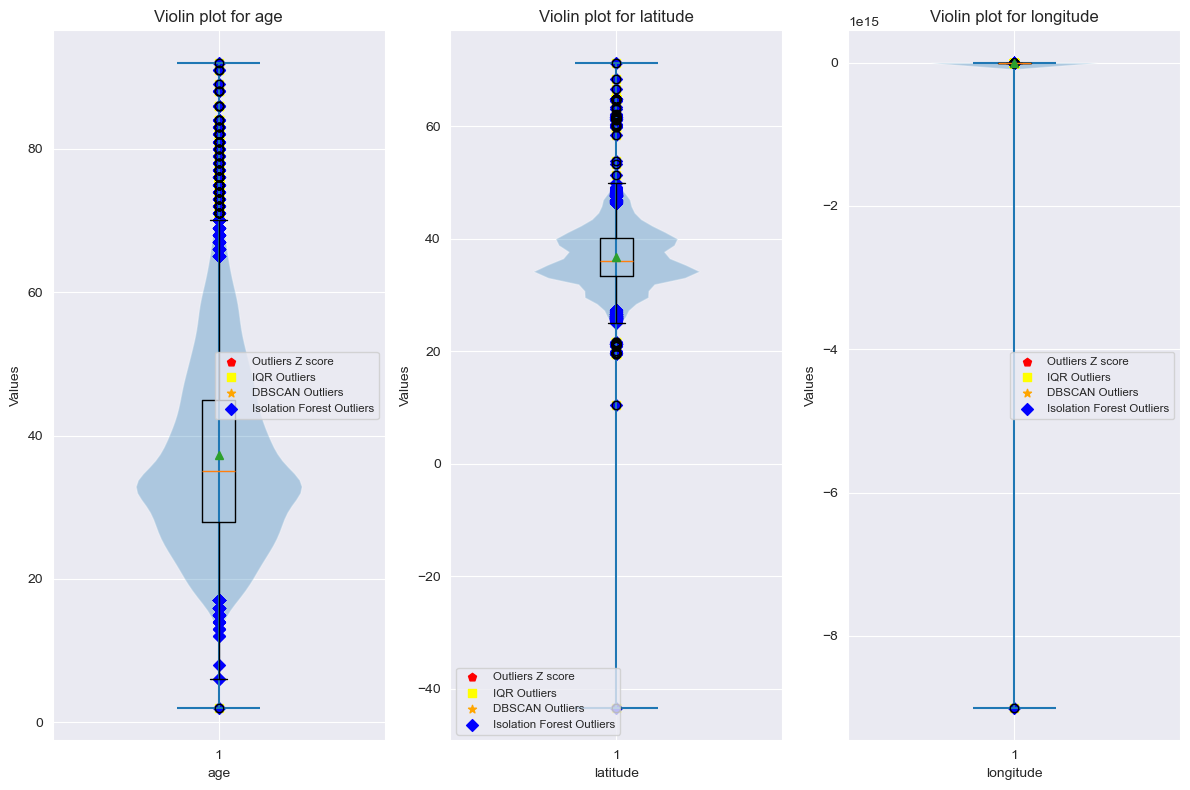

In [143]:
# Plotting outliers according to IQR and Z-score
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
numerical_columns = ["age", "latitude", "longitude"]
threshold = 3  # Standard deviations:3
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    # Calculating outliers according to Z-score
    z_score_column = zscore(final_merge[column])
    out_z_score = (z_score_column > threshold) | (
        z_score_column < -threshold
    )
    out_values_z_score = final_merge.loc[out_z_score, column]

    # Reshaping the pandas dataframe column for IsolationForest and DBSCAN
    reshaped = final_merge[column].values.reshape(-1, 1)

    # Calculating outliers according to DBSCAN
    dbscan = DBSCAN(eps=1.0, min_samples=5)
    outliers_dbscan = dbscan.fit_predict(reshaped) == -1
    outliers_values_dbscan = final_merge.loc[outliers_dbscan, column]

    # Calculating outliers according to IsolationForest
    isolation_forest = IsolationForest(contamination=0.05)
    outliers_isolation_forest = (
        isolation_forest.fit_predict(reshaped) == -1
    )
    outliers_values_isolationforest = final_merge.loc[
        outliers_isolation_forest, column
    ]

    # Calculating outliers according to IQR
    iqr = final_merge[column].quantile(0.75) - final_merge[
        column
    ].quantile(0.25)
    q_minimum = final_merge[column].quantile(0.25) - 1.5 * iqr
    q_maximum = final_merge[column].quantile(0.75) + 1.5 * iqr
    outliers_iqr = (final_merge[column] < q_minimum) | (
        final_merge[column] > q_maximum
    )
    outliers_values_iqr = final_merge.loc[outliers_iqr, column]

    # Identifying common outliers identified by all algorithms
    outlier_merged = pd.merge(
        outliers_values_dbscan,
        outliers_values_iqr,
        left_index=True,
        right_index=True,
        how="inner",
    )
    outlier_merged = pd.merge(
        outlier_merged,
        outliers_values_isolationforest,
        left_index=True,
        right_index=True,
        how="inner",
    )
    outlier_merged = pd.merge(
        outlier_merged,
        out_values_z_score,
        left_index=True,
        right_index=True,
        how="inner",
        suffixes=("_df1", "_df2"),
    )
    observation_identifiers = outlier_merged.index

    # Calculating mean, SD and median
    mean_value = round(final_merge[column].mean(), 3)
    sd_values_3 = round(final_merge[column].std() * 3, 3)
    median_value = round(final_merge[column].median(), 3)

    # Subplot parameters
    axes[i].violinplot(final_merge[column])
    axes[i].set_title(f"Violin plot for {column}")
    axes[i].boxplot(final_merge[column], widths=0.1, showmeans=True)
    axes[i].set_xlabel(f"{column}")
    axes[i].set_ylabel("Values")
    axes[i].set_color = "skyblue"

    # Z-score outliers
    axes[i].scatter(
        [1] * out_z_score.sum(),
        final_merge[column][out_z_score],
        color="red",
        marker="p",
        label="Outliers Z score",
    )

    # IQR outliers
    axes[i].scatter(
        [1] * outliers_iqr.sum(),
        final_merge[column][outliers_iqr],
        color="yellow",
        marker="s",
        label="IQR Outliers",
    )

    # DBSCAN outliers
    axes[i].scatter(
        [1] * outliers_dbscan.sum(),
        final_merge[column][outliers_dbscan],
        color="orange",
        marker="*",
        label="DBSCAN Outliers",
    )

    # Isolation Forest outliers
    axes[i].scatter(
        [1] * outliers_isolation_forest.sum(),
        final_merge[column][outliers_isolation_forest],
        color="blue",
        marker="D",
        label="Isolation Forest Outliers",
    )

    # Report output parameters
    z_criteria = final_merge.loc[out_z_score, column].empty
    iqr_criteria = final_merge.loc[outliers_iqr, column].empty
    if not z_criteria or not iqr_criteria:
        axes[i].legend(loc="best", fontsize="small")
        print("\033[92m" + f"The {column} statistics:" + "\033[0m")
        print(
            f"Normal distribution intervals for the {column}: "
            f"{-sd_values_3} to {sd_values_3}."
        )
        print(
            f"IQR intervals for the {column}: "
            f"{round(q_minimum,3)} to {round(q_maximum,3)}."
        )
        print(f"Mean for the {column}: {mean_value}.")
        print(f"Median for the {column}: {median_value}.")
        if outlier_merged.empty:
            print("No outliers found.")
        else:
            print(
                f"Outliers identified commonly: {observation_identifiers}"
            )
            print(outlier_merged)
        print("====================================================")

plt.tight_layout()
plt.show()

In [144]:
# Manual evaluation of latitude and longitude outliers
rows_to_retrieve = [
    1255,
    5313,
    5746,
    6118,
    7618,
    7116,
    7463,
    9228,
    9552,
    9473,
]
# Plotting outliers on map
mymap = folium.Map(location=[40.7128, -74.0060], zoom_start=1)

# Markers
for row in rows_to_retrieve:
    folium.Marker(
        location=[
            final_merge.loc[row, "latitude"],
            final_merge.loc[row, "longitude"],
        ],
        popup=row,
    ).add_to(mymap)

file_path = ("/Users/agnekrupinskaite/PycharmProjects/"
             "agkrupi-DWWP.4.1/Folium maps/"
             "'outliers_latitude_longitude.html")

mymap.save(file_path)
mymap

In [145]:
# Evaluating potential mistakes
indices_list = [7618, 6188, 7463, 5746]
selected_rows = final_merge.loc[indices_list]
selected_rows

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,...,pctaian_x_y,pct2prace_x_y,pcthispanic_x_y,pctwhite_y_y,pctblack_y_y,pctapi_y_y,pctaian_y_y,pct2prace_y_y,pcthispanic_y_y,ethnicolr_race
id,,,,,,,,,,,,,,,,,,,,,
7618,2021-05-27,shoot,not,gun,Clarkville,Waimakariri District,TN,-43.405319,172.621295,city_based,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pctwhite_x_x
6188,2020-09-24,shoot,foot,gun,Sebring,Highlands County,FL,27.425688,-81.511995,not_available,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pctwhite_x_x
7463,2021-12-31,attack,car,vehicle,Beaumont,Riverside,CA,53.352550,-113.415143,city_based,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pctwhite_x_x
5746,2020-04-13,shoot,car,gun,Lamont,Lamont County,CA,53.783451,-112.447814,city_based,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pctwhite_x_x


In [146]:
# Fixing mistakes
# Observation 7618 fixes
final_merge.loc[7618, "city"] = "Clarksville"
final_merge.loc[7618, "latitude"] = 36.5298
final_merge.loc[7618, "longitude"] = -87.3595
final_merge.loc[7618, "location_precision"] = "manual_correction"

# Observations 7463 fixes
final_merge.loc[7463, "city"] = "Beaumont"
final_merge.loc[7463, "latitude"] = 33.9295
final_merge.loc[7463, "longitude"] = -116.9772
final_merge.loc[7463, "location_precision"] = "manual_correction"

# Observations 5746 fixes
final_merge.loc[5746, "latitude"] = 35.2597
final_merge.loc[5746, "longitude"] = -118.9143
final_merge.loc[5746, "location_precision"] = "manual_correction"

# Observations 6188 fixes
final_merge.loc[6188, "latitude"] = 27.479319
final_merge.loc[6188, "longitude"] = -81.456017
final_merge.loc[7618, "location_precision"] = "manual_correction"

In [147]:
# Checking if mistakes are fixed
mymap = folium.Map(location=[40.7128, -74.0060], zoom_start=2)

# Markers
for row in indices_list:
    folium.Marker(
        location=[
            final_merge.loc[row, "latitude"],
            final_merge.loc[row, "longitude"],
        ],
        popup=row,
    ).add_to(mymap)

file_path = ("/Users/agnekrupinskaite/PycharmProjects/"
             "agkrupi-DWWP.4.1/Folium maps/"
             "'outliers_latitude_longitude_fix.html")

mymap.save(file_path)
mymap

### Statistical test
- After violin plots evaluation age, latitude and longitude data do not look distributed normally.
- Shapiro, Anderson, Kolmogorov-Smirnov and Jarque Bera tests are performed to evaluate normality.

In [148]:
# Shapiro test
age = washington_post["age"]
latitude = washington_post["latitude"]
longitude = washington_post["longitude"]

columns_to_test = {
    "age": age,
    "latitude": latitude,
    "longitude": longitude,
}
print("Shapiro test results:")
for column_name, column_data in columns_to_test.items():
    stat, p_value = shapiro(column_data)
    print(
        f"Shapiro test results for {column_name} "
        f"feature: Statistic: {stat}, p-value: {p_value}"
    )

Shapiro test results:
Shapiro test results for age feature: Statistic: 0.959419846534729, p-value: 4.203895392974451e-45
Shapiro test results for latitude feature: Statistic: 0.9555584788322449, p-value: 0.0
Shapiro test results for longitude feature: Statistic: 0.0017414689064025879, p-value: 0.0


/Users/agnekrupinskaite/anaconda3/envs/agkrupi-DWWP25/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [149]:
# Anderson test
columns_to_test = {
    "age": age,
    "latitude": latitude,
    "longitude": longitude,
}
print("Anderson test results:")
for column_name, column_data in columns_to_test.items():
    result = stats.anderson(column_data)
    print(f"Statistic for {column_name} "
          f"feature: {result.statistic}")
    print(
        f"Critical Values for {column_name} "
        f"feature: {result.critical_values}"
    )
    print(
        f"Significance Level for {column_name} "
        f"feature: {result.significance_level}"
    )
    print("==============================")

Anderson test results:
Statistic for age feature: 105.88631826759047
Critical Values for age feature: [0.576 0.656 0.787 0.918 1.092]
Significance Level for age feature: [15.  10.   5.   2.5  1. ]
Statistic for latitude feature: 34.07730906843608
Critical Values for latitude feature: [0.576 0.656 0.787 0.918 1.092]
Significance Level for latitude feature: [15.  10.   5.   2.5  1. ]
Statistic for longitude feature: 3622.40277736781
Critical Values for longitude feature: [0.576 0.656 0.787 0.918 1.092]
Significance Level for longitude feature: [15.  10.   5.   2.5  1. ]


In [150]:
# Kolmogorov-Smirnov test
columns_to_test = {
    "age": age,
    "latitude": latitude,
    "longitude": longitude,
}
print("Kolmogorov-Smirnov test results:")
for column_name, column_data in columns_to_test.items():
    statistic, p_value = kstest(column_data, "norm")
    print(f"Statistic for {column_name} feature: {statistic}.")
    print(f"The p-value for {column_name} feature: {p_value}.")
    print("==============================")

Kolmogorov-Smirnov test results:
Statistic for age feature: 0.9998933664691598.
The p-value for age feature: 0.0.
Statistic for latitude feature: 0.9998933674557475.
The p-value for latitude feature: 0.0.
Statistic for longitude feature: 0.9996801023672425.
The p-value for longitude feature: 0.0.


In [151]:
# Jarque Bera test
columns_to_test = {
    "age": age,
    "latitude": latitude,
    "longitude": longitude,
}
print("Jarque Bera test results:")
for column_name, column_data in columns_to_test.items():
    statistic, p_value = jarque_bera(column_data)
    print(f"Statistic for {column_name} feature: {statistic}.")
    print(f"The p-value for {column_name} feature: {p_value}.")
    print("==============================")

Jarque Bera test results:
Statistic for age feature: 974.7941868337894.
The p-value for age feature: 2.1190042773262213e-212.
Statistic for latitude feature: 20424.364444615014.
The p-value for latitude feature: 0.0.
Statistic for longitude feature: 34343264063.083298.
The p-value for longitude feature: 0.0.


#### Statistical tests conclusions
- Shapiro test shows that latitude, longitude and age are not normally distributed.
- Anderson test shows that latitude, longitude and age are not normally distributed.
- Kolmogorov-Smirnov test shows that latitude, longitude and age are not normally distributed.
- Jarque Bera test shows that latitude, longitude and age are not normally distributed.

All tests conclude that latitude, longitude and age features are not normally distributed.

## Feature correlation
- Numeric feature correlation is evaluated using Pearson and Spearman coefficients and plotted on heatmaps.

In [152]:
# Calculation of correlation matrix: Pearson
numeric_columns = final_merge[["age", "latitude", "longitude"]]
correlation_matrix_p = numeric_columns.corr().round(3)
correlated_pairs_p = correlation_matrix_p.unstack()

# Calculation of correlation matrix: Spearman
correlation_matrix_s = numeric_columns.corr(method="spearman").round(
    3
)
correlated_pairs = correlation_matrix_s.unstack()

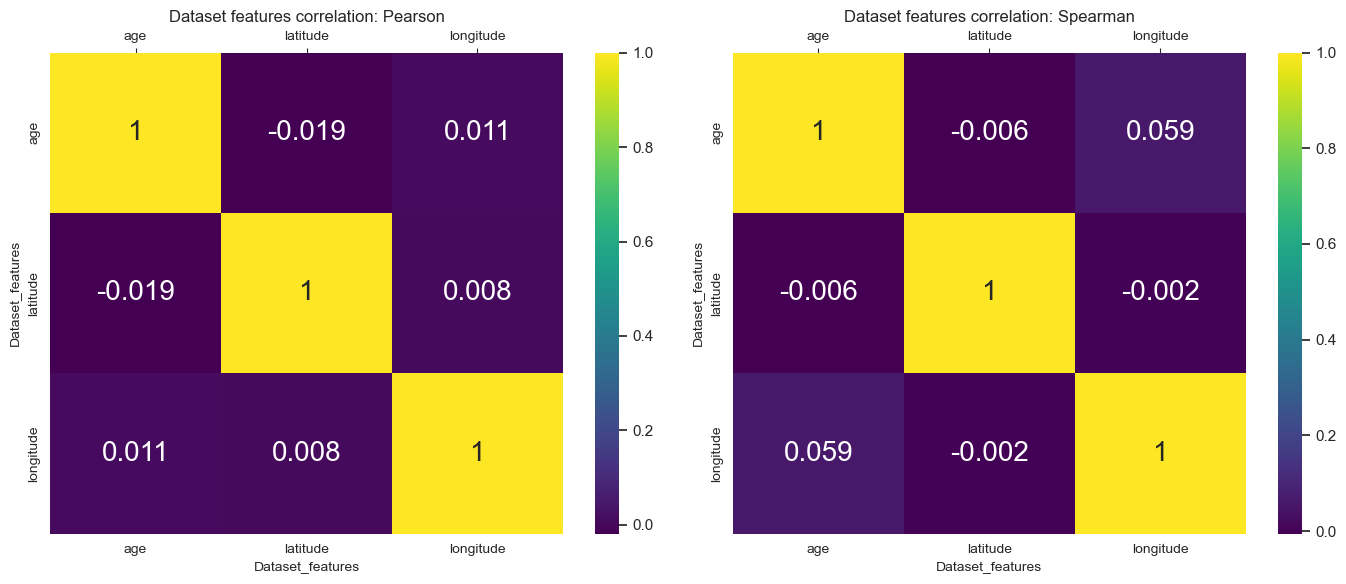

In [153]:
# Correlation heatmaps
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.set(font_scale=1)
sns.heatmap(
    correlation_matrix_p,
    annot=True,
    cmap="viridis",
    ax=ax[0],
    annot_kws={"size": 20},
)
sns.heatmap(
    correlation_matrix_s,
    annot=True,
    cmap="viridis",
    ax=ax[1],
    annot_kws={"size": 20},
)

ax[0].set_title("Dataset features correlation: Pearson")
ax[1].set_title("Dataset features correlation: Spearman")
ax[0].set_xlabel("Dataset_features")
ax[1].set_xlabel("Dataset_features")
ax[0].set_ylabel("Dataset_features")
ax[1].set_ylabel("Dataset_features")
ax[0].tick_params(axis="x", which="both", top=True, labeltop=True)
ax[1].tick_params(axis="x", which="both", top=True, labeltop=True)
plt.tight_layout()
plt.show()

#### Correlation evaluation
- Spearman correlation show that latitude, longitude and age features are not correlated.
- Pearson correlation also shows that latitude, longitude and age features are not correlated.

# Conclusions
1. Features imputed from Fatal Encounters dataset: name, age, gender, flee_status, armed_with, race, threat_type.
2. Guender-guesser library provided 7 guesses for missing data which were used for imputation.
3. Ethnicolor library was used to determine missing race values. However, algorthm performance with this dataset was poor. Ethnicolr algorithm identify race black correctly in 9.0% cases. This task is complicated and ethically controversial. Moreover, technical side of computational race determination is complicated do to surname length variability. Results were not used for further analysis. These results can be found in the washington_post_v4_full.csv.
4. New features created to show that values were imputed. For accuracy purposes.
5. Outliers in latitude and longitude features identified and manually corrected.
6. Duplicates of date and name removed.
7. Numerical features evaluated using statistical tests, and analysing violin plots. All of these tools confirmed that latitude, longitude and age features are not normally distributed.
8. Spearman and Pearson correlations coefficients also showed that age, latitude and longitude features are not correlated.
9. Maps generated during outlier corrections saved in Folium maps directory.

# Exporting dataset 
Dataset is exported in two ways:
- Full export: all the created features are exported.
- Clean export: features that are needed for further analysis.
- Dataset for clean export is standardised removing whitespaces, applying lowercase and uppercase methods to match format provided in the geojson files.

In [154]:
# Exporting to csv full_results
file_path = (
    "/Users/agnekrupinskaite/PycharmProjects/"
    "agkrupi-DWWP.4.1/Data_preprocessing_full_files/"
    "washington_post_v4_full.csv"
)
final_merge.to_csv(file_path, header=True, index=True)

In [155]:
# Removing columns with null values
for column in final_merge.columns:
    if final_merge[column].isnull().any():
        final_merge.drop(column, axis=1, inplace=True)

In [156]:
# Lowering letters, removing whitespaces
categorical_columns = [
    "threat_type",
    "flee_status",
    "armed_with",
    "city",
    "county",
    "location_precision",
    "gender",
    "race",
]

for column in categorical_columns:
    final_merge[column] = final_merge[column].str.lower()
    final_merge[column] = final_merge[column].str.strip()
    final_merge[column] = final_merge[column].replace(
        r"\s{2,}", " ", regex=True
    )
washington_post.head()

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,...,Retrieved_flee_status_v2,flee_status_source,Retrieved_armed_with_v1,Retrieved_armed_with_v2,armed_with_source,armed_with_v1,Retrieved_threat_type_v1,Retrieved_threat_type_v2,Retrieved_race_v1,Retrieved_race_v2
id,,,,,,,,,,,,,,,,,,,,,
3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,...,Not fleeing,Washington_Post,None,None,Washington_Post,NaN,None,Uncertain,Asian/Pacific Islander,Asian/Pacific Islander
4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,...,Not fleeing,Washington_Post,Firearm/Handgun,Firearm/Handgun,Washington_Post,Fatal_Encounters,Brandished weapon,Brandished weapon,European-American/White,European-American/White
5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,...,Not fleeing,Washington_Post,Edged weapon/Knife,Edged weapon/Knife,Washington_Post,Fatal_Encounters,Reached to waist,Reached to waist,Hispanic/Latino,Hispanic/Latino
8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,...,Not fleeing,Washington_Post,Firearm/Pellet gun,Firearm/Pellet gun,Washington_Post,Fatal_Encounters,Brandished weapon,Brandished weapon,European-American/White,European-American/White
9,2015-01-04,point,not,other_or_multiple,Evans,Weld,CO,40.383937,-104.692261,not_available,...,Not fleeing,Washington_Post,None,None,Washington_Post,NaN,None,Brandished weapon,Hispanic/Latino,Hispanic/Latino


In [157]:
# Normalising county names
if "county" in final_merge.columns:
    final_merge["county"] = final_merge["county"].astype(str)
    final_merge["county"] = final_merge["county"].str.strip()
    final_merge["county"] = final_merge["county"].str.replace(
        r"\scounty\b", "", regex=True
    )
else:
    print("The 'county' column does not exist in the DataFrame.")

# Formatting according to GeoJson file
final_merge["county"] = final_merge["county"].str.capitalize()
word_to_add = " County"
final_merge["state"] = final_merge["state"].str.upper()

In [158]:
# Checking columns composition
print(final_merge.columns)

Index(['date', 'threat_type', 'flee_status', 'armed_with', 'city', 'county',
       'state', 'latitude', 'longitude', 'location_precision', 'name', 'age',
       'gender', 'race', 'was_mental_illness_related', 'body_camera',
       'agency_ids', 'name_source', 'first_name', 'second_name', 'third_name',
       'fourth_name', 'fifth_name', 'Retrieved_gender_v1',
       'Retrieved_gender_guesser', 'gender_source', 'age_source',
       'flee_status_source', 'armed_with_source', 'pctwhite_x_x',
       'pctblack_x_x', 'pctapi_x_x', 'pctaian_x_x', 'pct2prace_x_x',
       'pcthispanic_x_x', 'pctwhite_y_x', 'pctblack_y_x', 'pctapi_y_x',
       'pctaian_y_x', 'pct2prace_y_x', 'pcthispanic_y_x', 'pctwhite_x_y',
       'pctblack_x_y', 'pctapi_x_y', 'pctaian_x_y', 'pct2prace_x_y',
       'pcthispanic_x_y', 'pctwhite_y_y', 'pctblack_y_y', 'pctapi_y_y',
       'pctaian_y_y', 'pct2prace_y_y', 'pcthispanic_y_y', 'ethnicolr_race'],
      dtype='object')


In [159]:
# Removing not needed columns
not_needed_columns = [
    "first_name",
    "second_name",
    "third_name",
    "fourth_name",
    "fifth_name",
    "pctwhite_x_x",
    "pctblack_x_x",
    "pctapi_x_x",
    "pctaian_x_x",
    "pct2prace_x_x",
    "pcthispanic_x_x",
    "pctwhite_y_x",
    "pctblack_y_x",
    "pctapi_y_x",
    "pctaian_y_x",
    "pct2prace_y_x",
    "pcthispanic_y_x",
    "pctwhite_x_y",
    "pctblack_x_y",
    "pctapi_x_y",
    "pctaian_x_y",
    "pct2prace_x_y",
    "pcthispanic_x_y",
    "pctwhite_y_y",
    "pctblack_y_y",
    "pctapi_y_y",
    "pctaian_y_y",
    "pct2prace_y_y",
    "pcthispanic_y_y",
    "ethnicolr_race",
    "Retrieved_gender_v1",
    "Retrieved_gender_guesser",
]

for column in not_needed_columns:
    final_merge.drop(column, axis=1, inplace=True)

In [160]:
# Checking columns composition
print(final_merge.columns)

Index(['date', 'threat_type', 'flee_status', 'armed_with', 'city', 'county',
       'state', 'latitude', 'longitude', 'location_precision', 'name', 'age',
       'gender', 'race', 'was_mental_illness_related', 'body_camera',
       'agency_ids', 'name_source', 'gender_source', 'age_source',
       'flee_status_source', 'armed_with_source'],
      dtype='object')


In [161]:
# Exporting to csv cleaned data
final_merge.to_csv(
    "washington_post_v4_clean.csv", header=True, index=True
)